In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time
import h5py
from pathlib import Path

from tomobar.methodsDIR import RecToolsDIR
from tomobar.supp.suppTools import normaliser

In [2]:
#Data shape: [n_sample, c, h, w]

In [32]:
#13076:  
n_darks = 20  
n_flats = 40  
n_projections = -20  
#n_post_flats = 0  
vert_tuple = [i for i in range(600,1000)]
horiz_tuple = [i for i in range(200,1000)]
# Angles = (1841)

In [33]:
PATH = "/dls/science/users/lqg38422/data/13076/13076.nxs"

h5py_list = h5py.File(PATH, "r")

darks = h5py_list['/entry1/instrument/flyScanDetector/data'][:n_darks,vert_tuple,:][:,:,horiz_tuple]
darks = darks.transpose((1,0,2))
flats = h5py_list['/entry1/instrument/flyScanDetector/data'][n_darks:n_flats,vert_tuple,:][:,:,horiz_tuple]
flats = flats.transpose((1,0,2))
data_raw = h5py_list['/entry1/instrument/flyScanDetector/data'][n_flats:n_projections,vert_tuple,:][:,:,horiz_tuple]
data_raw = data_raw.transpose((1,0,2))
projData3D_norm = normaliser(data_raw, flats=flats, darks=darks, log='true', method='mean')
angles = h5py_list['/entry1/tomo_entry/data/rotation_angle'][:] # extract angles
angles_rad = angles[40:1841]*np.pi/180.0

h5py_list.close()
del darks, flats, data_raw

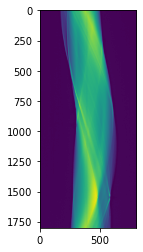

In [35]:
plt.imshow(projData3D_norm[1,:,:])

In [41]:
def split_rec(projData3D_norm, detHor, detVert, N_size, angles_rad, center_rot, num_splits = 4):
        # Reconstruct
        print("FUNCTION")
        RectoolsDIR = RecToolsDIR(DetectorsDimH = detHor,  # DetectorsDimH # detector dimension (horizontal)
                        DetectorsDimV = detVert,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                        CenterRotOffset = center_rot, # Center of Rotation (CoR) scalar (for 3D case only)
                        AnglesVec = angles_rad, # array of angles in radians
                        ObjSize = N_size, # a scalar to define reconstructed object dimensions
                        device_projector = 'gpu')

        print("FBP - Noisy projection")
        tmp = RectoolsDIR.FBP(projData3D_norm) # FBP reconstruction
    
        # Reconstruct noisy splits
        print("FBP - Split projection")
        noisy_splits_rec_tmp = [] #/0, /1, /2, ...
        for j in range(num_splits):
            RectoolsDIR = RecToolsDIR(DetectorsDimH = detHor,  # DetectorsDimH # detector dimension (horizontal)
                            DetectorsDimV = detVert,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                            CenterRotOffset = center_rot, # Center of Rotation (CoR) scalar (for 3D case only)
                            AnglesVec = angles_rad[j::num_splits], # array of angles in radians
                            ObjSize = N_size, # a scalar to define reconstructed object dimensions
                            device_projector = 'gpu')
            sino_split = projData3D_norm[:, j::num_splits, :]
            rec = RectoolsDIR.FBP(sino_split)
            rec = torch.tensor(rec)
            noisy_splits_rec_tmp.append(rec)
        
        return torch.tensor(tmp), torch.stack(noisy_splits_rec_tmp)

In [42]:
#(1800, 1199) != ... len(angles_rad) should be equal to sino_shape (projData3D_norm.shape[1])

In [43]:
N_size = projData3D_norm.shape[2]
detHor = projData3D_norm.shape[2]
detVert = projData3D_norm.shape[0]
center_rot = 25

In [44]:
noisy_rec, noisy_splits_rec = split_rec(projData3D_norm, detHor, detVert, N_size, angles_rad, center_rot, num_splits = 32)

FUNCTION
FBP - Noisy projection
FBP - Split projection


slice_num: 180


(<AxesSubplot:title={'center':'SPLIT DATA'}>,
 Text(0.5, 1.0, 'SPLIT DATA'),
 <matplotlib.image.AxesImage at 0x2b9ad62e5d30>)

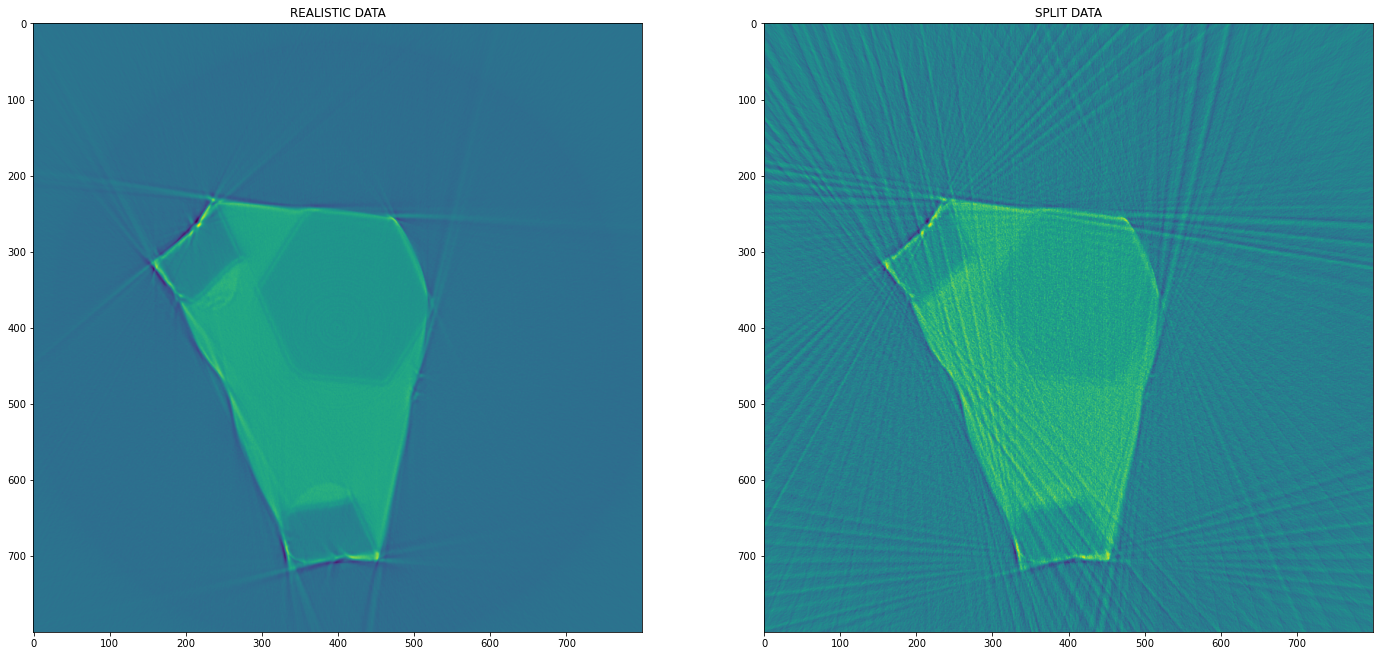

In [47]:
slice_num = np.random.randint(0, noisy_rec.shape[0])
print("slice_num:", slice_num)
plt.figure(figsize=(24,24))
plt.subplot(1,2,1), plt.title("REALISTIC DATA"), plt.imshow(noisy_rec[slice_num,:,:])
plt.subplot(1,2,2), plt.title("SPLIT DATA"), plt.imshow(noisy_splits_rec[0][slice_num,:,:])

In [52]:
import matplotlib.pyplot as plt
import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython import display

def noise2inverse_train(noisy_splits_rec):
    # Parameters
    output_dir = Path("weights")
    
    num_splits = 4
    strategy = "X:1"
    epochs = 1 #100
    batch_size = 16
    multi_gpu = True
    # Scale pixel intensities during training such that its values roughly occupy the range [0,1].
    # This improves convergence.
    data_scaling = 100
    
    datasets = noisy_splits_rec.unsqueeze(2)
    train_ds = Noise2InverseDataset(*datasets, strategy=strategy) #[256, 1, 256, 256] x4
    
    dl = DataLoader(train_ds, batch_size, shuffle=True,)
    model = MSDRegressionModel(1, 1, 100, 1, parallel=multi_gpu)

    output_dir.mkdir(exist_ok=True)
    
    train_epochs = max(epochs // num_splits, 1)
    
    # Training
    loss_track = []
    update_plot = 4
    for epoch in range(train_epochs):
        print(f"EPOCH {epoch}: ")
        epoch_loss = []
        it = 0
        # Train
        for (inp, tgt) in tqdm(dl):
            inp = inp.cuda(non_blocking=True) * data_scaling
            tgt = tgt.cuda(non_blocking=True) * data_scaling

            # Do training step with masking
            model.output = model.net(inp)
            model.loss = model.criterion(model.output, tgt)
            # Loss
            epoch_loss.append(model.loss.item())
            loss_track.append(model.loss.item())
            if it % update_plot == 0:
                plt.title(f"EPOCH {epoch} - Mean Loss: {np.mean(epoch_loss)}")
                plt.plot(loss_track)
                display.clear_output(wait=True)
                display.display(plt.gcf())
            model.optimizer.zero_grad()
            model.loss.backward()
            model.optimizer.step()
            it += 1
    model.save(output_dir / "weights.torch", epoch)

In [53]:
import tifffile
import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm

def noise2inverse_pred(noisy_splits_rec):
    # Parameters
    weights_path = Path("weights/weights.torch")

    num_splits = 4
    strategy = "X:1"
    batch_size = num_splits
    multi_gpu = True
    # Scale pixel intensities in the same way as during training.
    data_scaling = 100

    datasets = noisy_splits_rec.unsqueeze(2)
    ds = Noise2InverseDataset(*datasets, strategy=strategy)

    # Dataloader and network:
    dl = DataLoader(ds, batch_size, shuffle=False,)
    model = MSDRegressionModel(1, 1, 100, 1, parallel=True)
    model.load(weights_path)

    # Put network in evaluation mode: this should be done when the network uses batch norm for instance.
    model.net.eval()
    denoised_rec = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dl)):
            inp, _ = batch     
            inp = inp.cuda() * data_scaling
            out = model.net(inp)
            # Take mean over batch dimension (splits):
            out = out.mean(dim=0) / data_scaling
            # Obtain 2D numpy array
            out_np = out.detach().cpu().numpy().squeeze()
            denoised_rec.append(out_np)
    return np.array(denoised_rec)

In [54]:
def noise2inverse_all(noisy_splits_rec):
    torch.cuda.empty_cache() #before we start training
    noise2inverse_train(noisy_splits_rec)
    denoised_rec = noise2inverse_pred(noisy_splits_rec)
    return denoised_rec

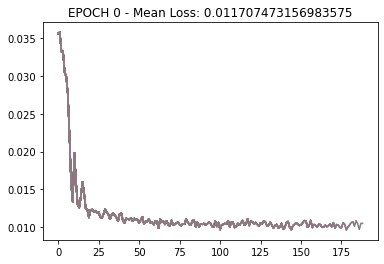

 24%|██▍       | 190/800 [27:41<1:28:56,  8.75s/it]

In [ ]:
denoised_rec = noise2inverse_all(noisy_splits_rec)

slice_num: 314


(<AxesSubplot:title={'center':'DENOISED'}>,
 Text(0.5, 1.0, 'DENOISED'),
 <matplotlib.image.AxesImage at 0x2b9ad5ed7c18>)

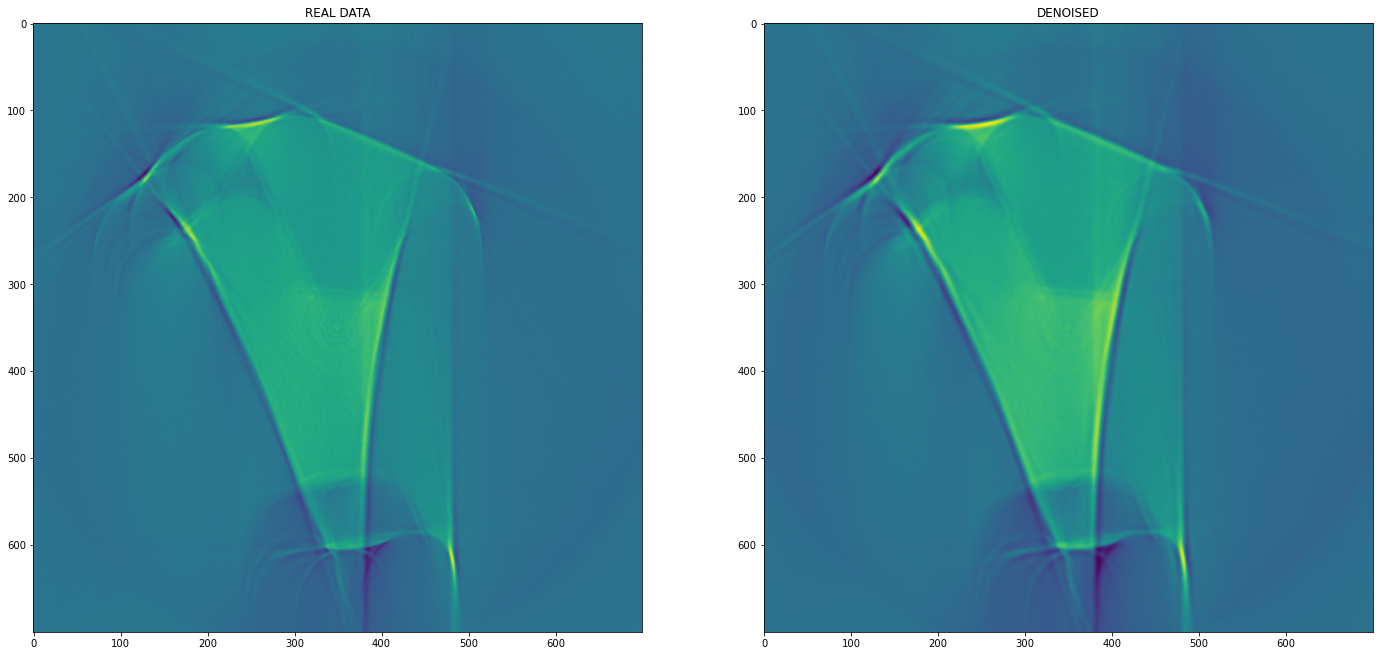

In [26]:
slice_num = np.random.randint(0, noisy_rec.shape[0])
print("slice_num:", slice_num)
plt.figure(figsize=(24,24))
plt.subplot(1,2,1), plt.title("REAL DATA"), plt.imshow(noisy_rec[:,slice_num,:])
plt.subplot(1,2,2), plt.title("DENOISED"), plt.imshow(denoised_rec[:,slice_num,:])